In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras.regularizers import l2

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = "drive/MyDrive/Colab Notebooks/Recyclable and Household Waste Classification/images/images"
# Define the training dataset
train_dataset = image_dataset_from_directory(
    directory,
    labels='inferred',  # Automatically infers labels from subdirectory names
    label_mode='categorical',  # Return labels as one-hot encoded vectors
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.5,  # 20% for validation
    subset='training',
    seed=42
)

# Define the validation dataset
validation_dataset = image_dataset_from_directory(
    directory,
    labels='inferred',  # Automatically infers labels from subdirectory names
    label_mode='categorical',  # Return labels as one-hot encoded vectors
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.3,  # 20% for validation
    subset='validation',
    seed=42
)

# Verify the dataset structure
class_names = train_dataset.class_names
print(f"Class names: {class_names}")

for image_batch, label_batch in train_dataset.take(1):
    print(f"Image batch shape: {image_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")
    print(f"Labels: {label_batch.numpy()}")

Found 15023 files belonging to 30 classes.
Using 7512 files for training.


KeyboardInterrupt: 

In [ ]:
class_names = train_dataset.class_names
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")

Class names: ['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging', 'clothing', 'coffee_grounds', 'disposable_plastic_cutlery', 'eggshells', 'food_waste', 'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'newspaper', 'office_paper', 'paper_cups', 'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers', 'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags', 'plastic_water_bottles', 'shoes', 'steel_food_cans', 'styrofoam_cups', 'styrofoam_food_containers', 'tea_bags']
Number of classes: 30


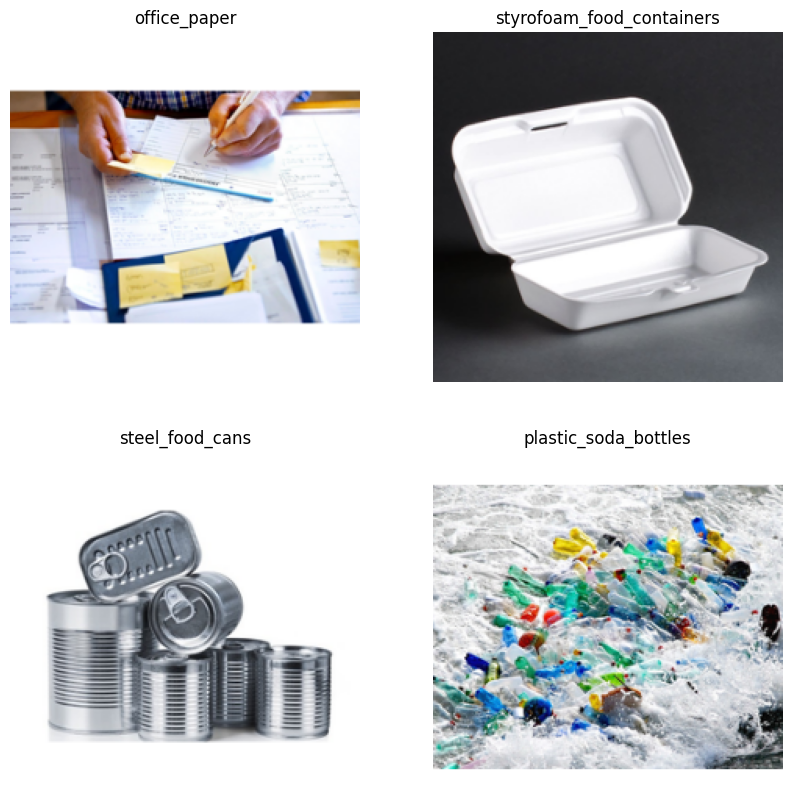

In [ ]:
# Verify the dataset structure and plot some examples
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = tf.argmax(labels[i]).numpy()  # Get the index of the highest value (class)
        plt.title(class_names[label_index])
        plt.axis("off")

plt.show()

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
def data_augmenter():
    '''
    Returns:
        tf.keras.Sequential
    '''

    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    data_augmentation.add(RandomZoom(0.2))
    data_augmentation.add(RandomContrast(0.2))

    return data_augmentation

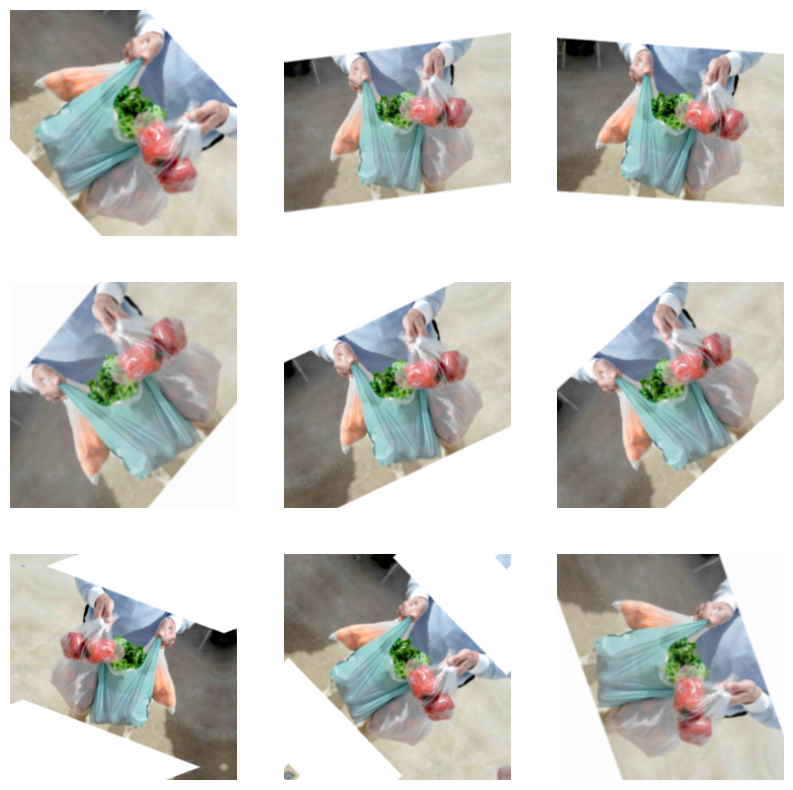

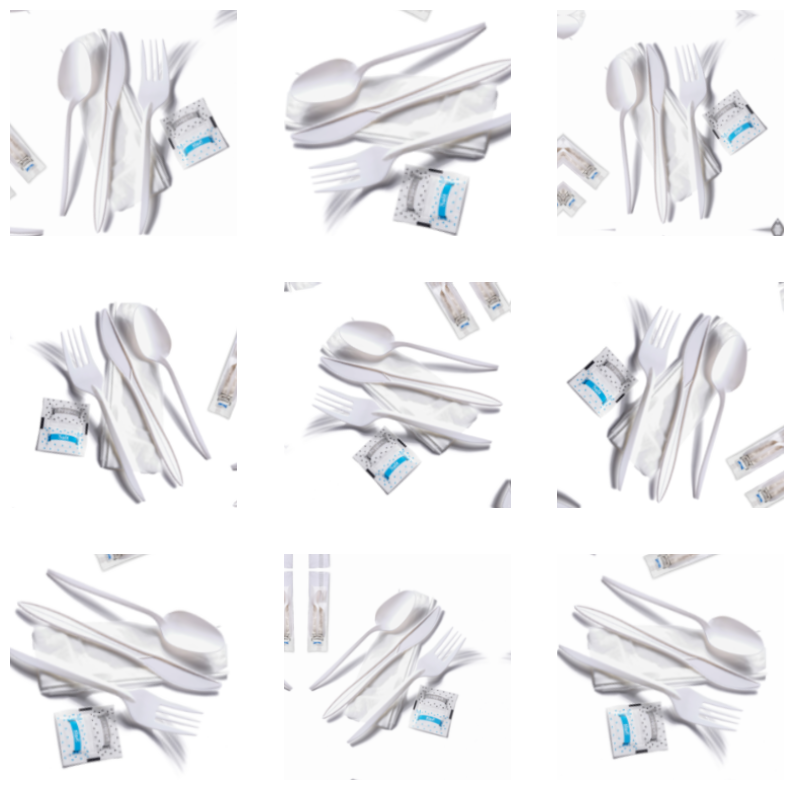

In [ ]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(2):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

102967424/102967424 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
nb_layers = len(base_model.layers)
print('total layers:',nb_layers)
print('second last layer:',base_model.layers[nb_layers - 2].name)
print('last layer:',base_model.layers[nb_layers - 1].name)

total layers: 177
second last layer: avg_pool
last layer: predictions


In [ ]:
num_classes = len(class_names)

def model(image_shape=IMG_SIZE, data_augmentation=data_augmenter(),num_classes=num_classes,dropout_rate=0.4):
    '''
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
        num_classes -- number of category classes
        dropout_rate -- droupout_rate for the classifaction layer
    Returns:
        tf.keras.model
    '''

    input_shape = image_shape + (3,)

    base_model = tf.keras.applications.ResNet50(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet

    # freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer
    inputs = tf.keras.Input(shape=input_shape)

    # apply data augmentation to the inputs
    x = data_augmentation(inputs)

    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x)

    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)

    # add the new  classification layers
    # global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x)
    # dropout layer to avoid overfitting
    x = tfl.Dropout(rate=dropout_rate)(x)
    # a prediction layer with num_classes neurons with l2 regularizer
    outputs = tfl.Dense(units=num_classes,kernel_regularizer=l2(0.01))(x)


    model = tf.keras.Model(inputs, outputs)

    return model

In [ ]:
model2 = model(IMG_SIZE, data_augmentation)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 10
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/10
235/235 [==============================] - 209s 873ms/step - loss: 2.5043 - accuracy: 0.4627 - val_loss: 1.3951 - val_accuracy: 0.7330
Epoch 2/10
235/235 [==============================] - 201s 856ms/step - loss: 1.6388 - accuracy: 0.6427 - val_loss: 1.1765 - val_accuracy: 0.7599
Epoch 3/10
235/235 [==============================] - 201s 857ms/step - loss: 1.3982 - accuracy: 0.6916 - val_loss: 1.0961 - val_accuracy: 0.7690
Epoch 4/10
235/235 [==============================] - 198s 840ms/step - loss: 1.3147 - accuracy: 0.7073 - val_loss: 1.0237 - val_accuracy: 0.7923
Epoch 5/10
235/235 [==============================] - 201s 856ms/step - loss: 1.2755 - accuracy: 0.7071 - val_loss: 1.0221 - val_accuracy: 0.7798
Epoch 6/10
235/235 [==============================] - 203s 865ms/step - loss: 1.2491 - accuracy: 0.7179 - val_loss: 1.0387 - val_accuracy: 0.7739
Epoch 7/10
235/235 [==============================] - 201s 856ms/step - loss: 1.2244 - accuracy: 0.7206 - val_loss: 0.9963 -

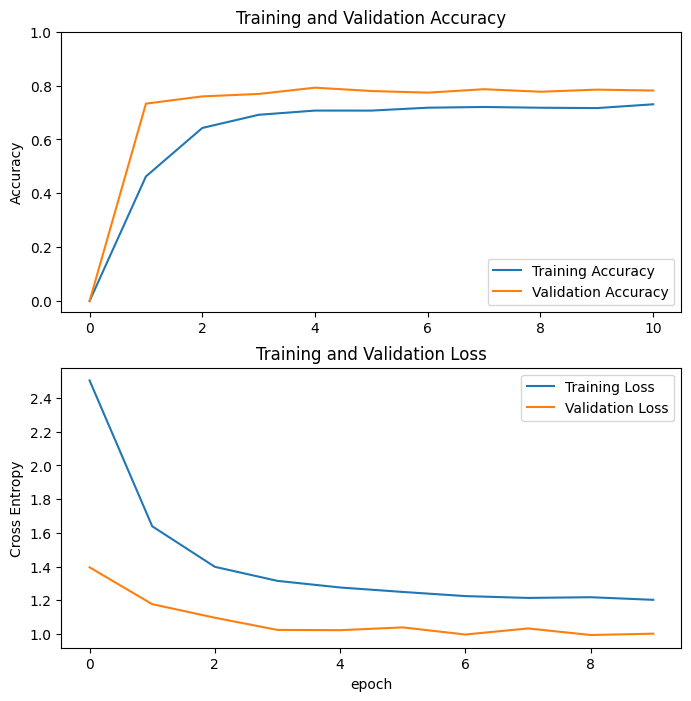

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Let's take a look to see how many layers are in the base model
base_model = model2.layers[1]
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  4


In [ ]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 150

In [ ]:
# Freeze all the layers before the `fine_tune_at` layer
for layer in model2.layers[:fine_tune_at]:
    layer.trainable = False

# Define a CategoricalCrossentropy loss function.
loss_function=tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate)

# Use accuracy as evaluation metric
metrics=['accuracy']


model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
235/235 [==============================] - 205s 858ms/step - loss: 1.1495 - accuracy: 0.7396 - val_loss: 1.0012 - val_accuracy: 0.7816
Epoch 11/20
235/235 [==============================] - 201s 855ms/step - loss: 1.1469 - accuracy: 0.7404 - val_loss: 1.0012 - val_accuracy: 0.7816
Epoch 12/20
235/235 [==============================] - 202s 857ms/step - loss: 1.1560 - accuracy: 0.7391 - val_loss: 1.0012 - val_accuracy: 0.7816
Epoch 13/20
235/235 [==============================] - 199s 845ms/step - loss: 1.1387 - accuracy: 0.7468 - val_loss: 1.0012 - val_accuracy: 0.7816
Epoch 14/20
235/235 [==============================] - 201s 854ms/step - loss: 1.1527 - accuracy: 0.7416 - val_loss: 1.0012 - val_accuracy: 0.7816
Epoch 15/20
235/235 [==============================] - 204s 866ms/step - loss: 1.1357 - accuracy: 0.7519 - val_loss: 1.0012 - val_accuracy: 0.7816
Epoch 16/20
235/235 [==============================] - 200s 850ms/step - loss: 1.1477 - accuracy: 0.7416 - val_loss: 1

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

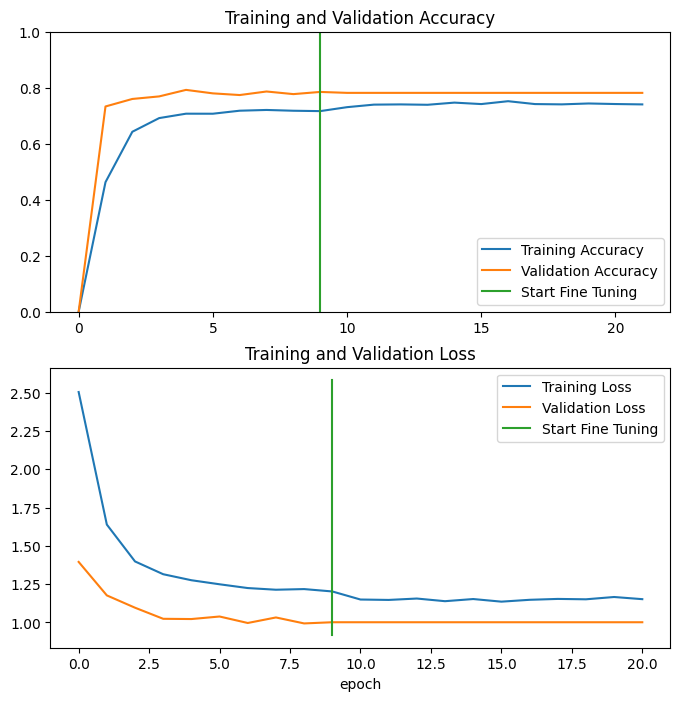

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

1/1 [==============================] - 1s 576ms/step


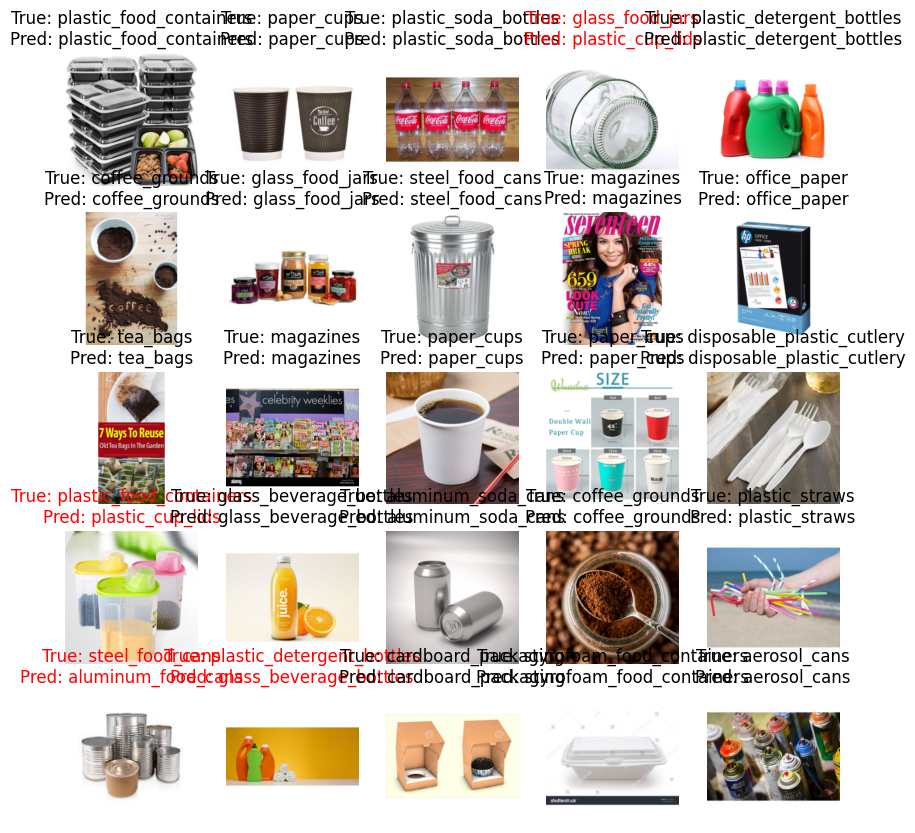

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in validation_dataset.take(1):
    # Predict the labels for the batch of images
    predictions = model2.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)

    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        true_label_index = tf.argmax(labels[i]).numpy()  # Get the index of the highest value (true class)
        predicted_label_index = predicted_labels[i].numpy()  # Get the index of the highest value (predicted class)

        true_label_name = class_names[true_label_index]
        predicted_label_name = class_names[predicted_label_index]

        if true_label_name == predicted_label_name:
            plt.title(f'True: {true_label_name}\nPred: {predicted_label_name}')
        else:
            plt.title(f'True: {true_label_name}\nPred: {predicted_label_name}', fontdict={'color': 'red'})
        plt.axis("off")

plt.show()

In [ ]:
save_dir = 'models'
os.makedirs(save_dir, exist_ok=True)

# Define the file path within this directory
model_path = os.path.join(save_dir, 'fine_tuned_resnet50.keras')

# Save the model
model2.save(model_path)

print(f"Model saved to {model_path}")

TypeError: Cannot serialize object Ellipsis of type <class 'ellipsis'>. To be serializable, a class must implement the `get_config()` method.